# Anomaly Detection with Machine Temperature Data (LSTM Autoencoder)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

In [ ]:
df = pd.read_csv("data/machine_temperature_system_failure.csv")

In [5]:
df.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22695 entries, 0 to 22694
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  22695 non-null  object 
 1   value      22695 non-null  float64
dtypes: float64(1), object(1)
memory usage: 354.7+ KB


In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')

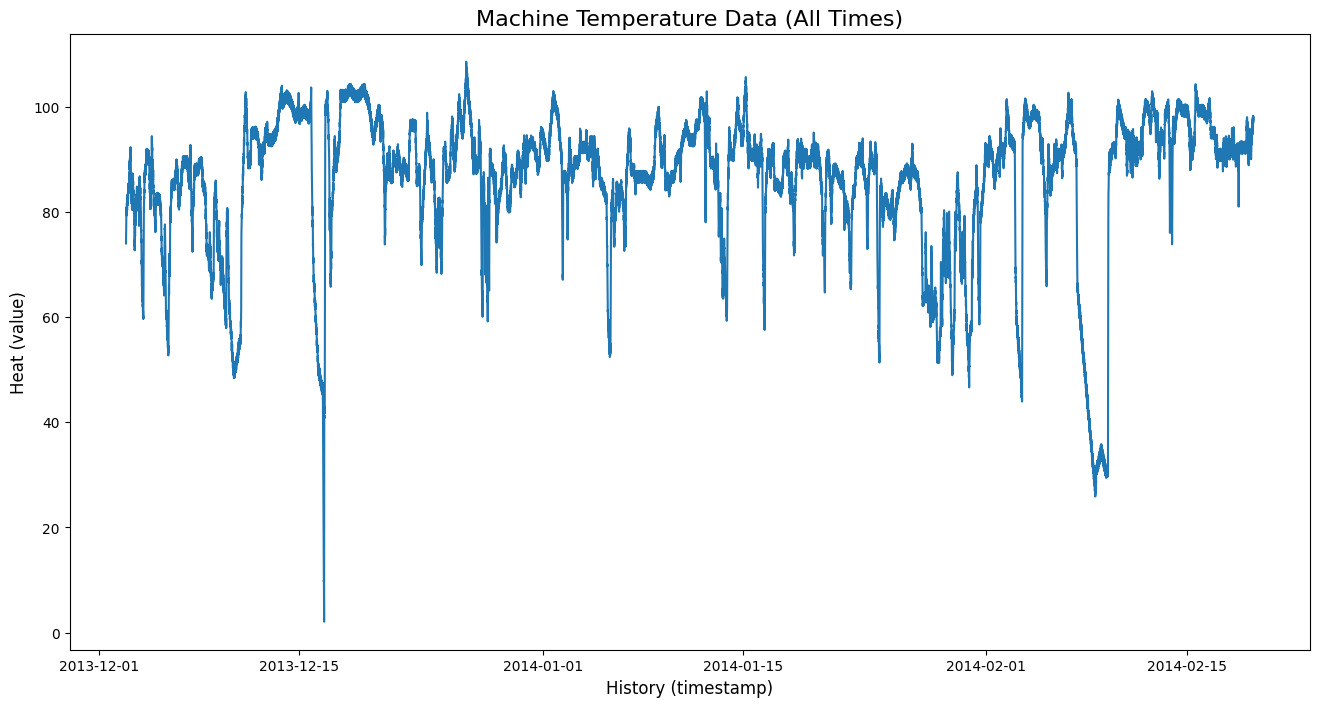

In [8]:
plt.figure(figsize=(16, 8))
plt.plot(df['value'])
plt.title('Machine Temperature Data (All Times)', fontsize=16)
plt.ylabel('Heat (value)', fontsize=12)
plt.xlabel('History (timestamp)', fontsize=12)
plt.show()

## Data Preprocessing

In [10]:
CUTOFF_DATE = '2013-12-11 06:00:00'
train_df = df[df.index < CUTOFF_DATE]
test_df = df[df.index >= CUTOFF_DATE]

In [11]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(train_df[['value']])

train_scaled = scaler.transform(train_df[['value']])
test_scaled = scaler.transform(test_df[['value']])

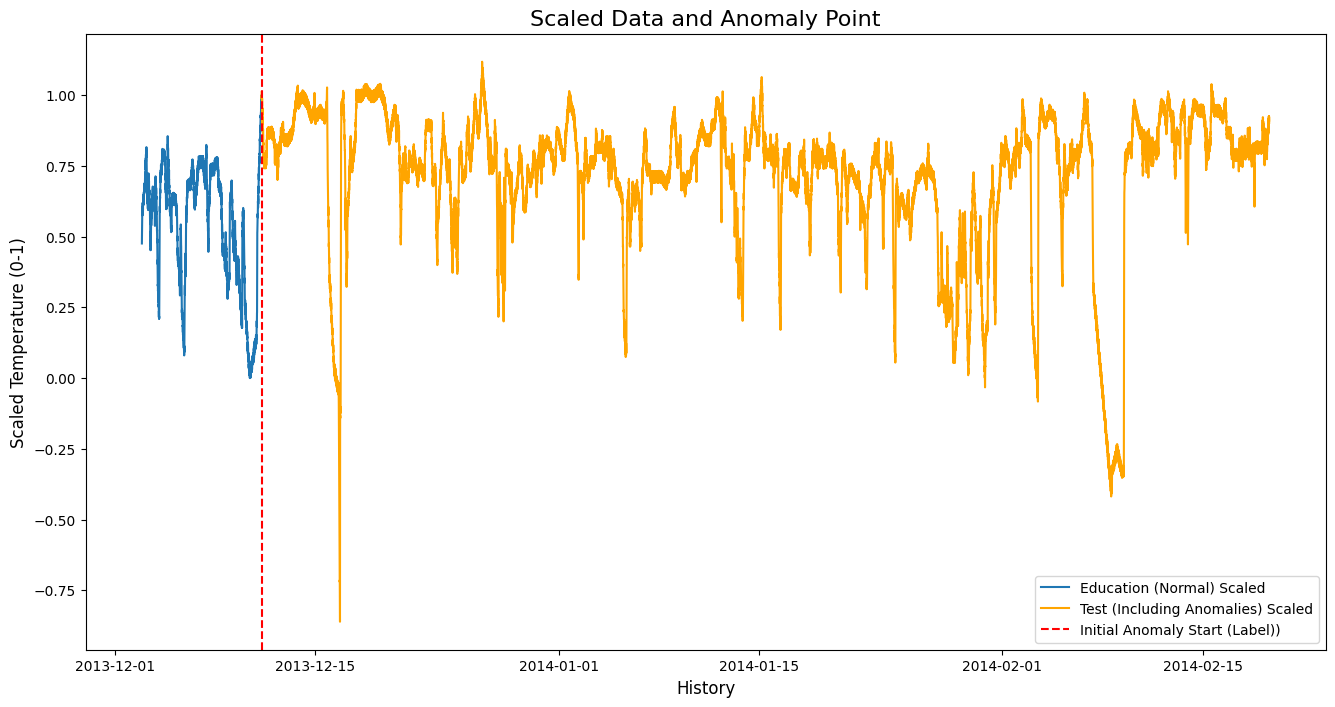

In [12]:
plt.figure(figsize=(16, 8))
plt.plot(train_df.index, train_scaled, label='Education (Normal) Scaled')
plt.plot(test_df.index, test_scaled, label='Test (Including Anomalies) Scaled', color='orange')
plt.axvline(pd.to_datetime(CUTOFF_DATE), color='red', linestyle='--', label='Initial Anomaly Start (Label))')
plt.title('Scaled Data and Anomaly Point', fontsize=16)
plt.ylabel('Scaled Temperature (0-1)', fontsize=12)
plt.xlabel('History', fontsize=12)
plt.legend()
plt.show()

## Segmenting Data into Sequences

In [14]:
def create_sequences(data,time_step):
    X,y=[],[]
    for i in range(len(data)-time_step):
        X.append(data[i:(i+time_step),0])
        y.append(data[i:(i+time_step),0])
    return np.array(X),np.array(y)

In [15]:
TIME_STEP = 60

X_train, y_train = create_sequences(train_scaled, TIME_STEP)
X_test, y_test = create_sequences(test_scaled, TIME_STEP)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], 1))

## Model Architecture - LSTM Autoencoder

In [17]:
input_shape = (X_train.shape[1],X_train.shape[2])
inputs = Input(shape=input_shape)

encoder = LSTM(128, activation="tanh",return_sequences=True)(inputs)
encoder = LSTM(64, activation="tanh",return_sequences=False)(encoder)

decoder = RepeatVector(input_shape[0])(encoder)
decoder = LSTM(64,activation="tanh",return_sequences=True)(decoder)
decoder = LSTM(128,activation="tanh",return_sequences=True)(decoder)

outputs = TimeDistributed(Dense(input_shape[1]))(decoder)

model = Model(inputs=inputs, outputs=outputs)

optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer,loss="mae")

In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 60, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 60, 1)          │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,937 (968.50 KB)

 Trainable params: 247,937 (968.50 KB)

 Non-trainable params: 0 (0.00 B)

## Training the Model

In [ ]:
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

epochs = 50
batch_size = 32

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    shuffle=False,
    verbose=1,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

model = load_model('models/best_model.keras')

Epoch 1/50
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.2839
Epoch 1: val_loss improved from None to 0.18352, saving model to best_model.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - loss: 0.1986 - val_loss: 0.1835
Epoch 2/50
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2326
Epoch 2: val_loss did not improve from 0.18352
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.1805 - val_loss: 0.1875
Epoch 3/50
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2195
Epoch 3: val_loss did not improve from 0.18352
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.1686 - val_loss: 0.1987
Epoch 4/50
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1751
Epoch 4: val_loss improved from 0.18352 to 0.14444, saving model to best_model.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.1472 - val_loss: 0.1444
Epoch 5/50
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1667
Epoch 5: val_loss did not improve from 0.14444
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.1405 - val_loss

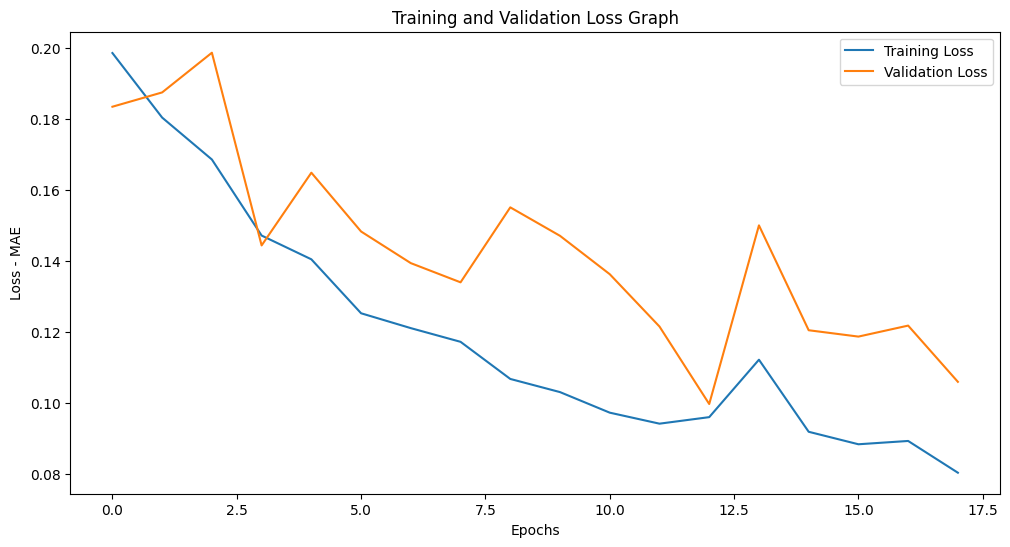

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss - MAE')
plt.legend()
plt.show()

In [22]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=(1, 2))
train_mae_loss.shape

74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step   


(2349,)

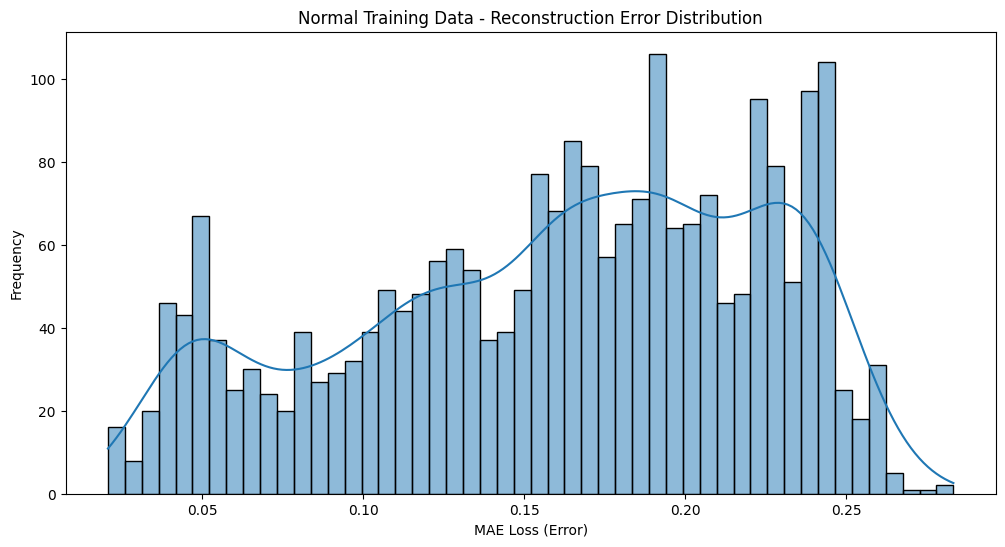

In [23]:
plt.figure(figsize=(12, 6))
sns.histplot(train_mae_loss, bins=50, kde=True)
plt.title('Normal Training Data - Reconstruction Error Distribution')
plt.xlabel('MAE Loss (Error)')
plt.ylabel('Frequency')
plt.show()

## Determining the Anomaly Threshold

In [25]:
THRESHOLD = np.percentile(train_mae_loss, 99)
print(f"\n Threshold Value :{THRESHOLD:.4f}")


 Threshold Value :0.2606


In [26]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=(1,2))
test_mae_loss.shape

633/633 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step


(20226,)

In [27]:
anomalies_mask = (test_mae_loss > THRESHOLD)

slice_start = TIME_STEP - 1
slice_end = (TIME_STEP - 1) + len(test_mae_loss)
start_index = TIME_STEP - 1
end_index = start_index + len(test_mae_loss)
anomaly_df = test_df.iloc[start_index:end_index].copy()

anomaly_df['loss'] = test_mae_loss
anomaly_df['anomaly'] = anomalies_mask
anomalous_points = anomaly_df[anomaly_df['anomaly']]

## Evaluation and Visualization of Results

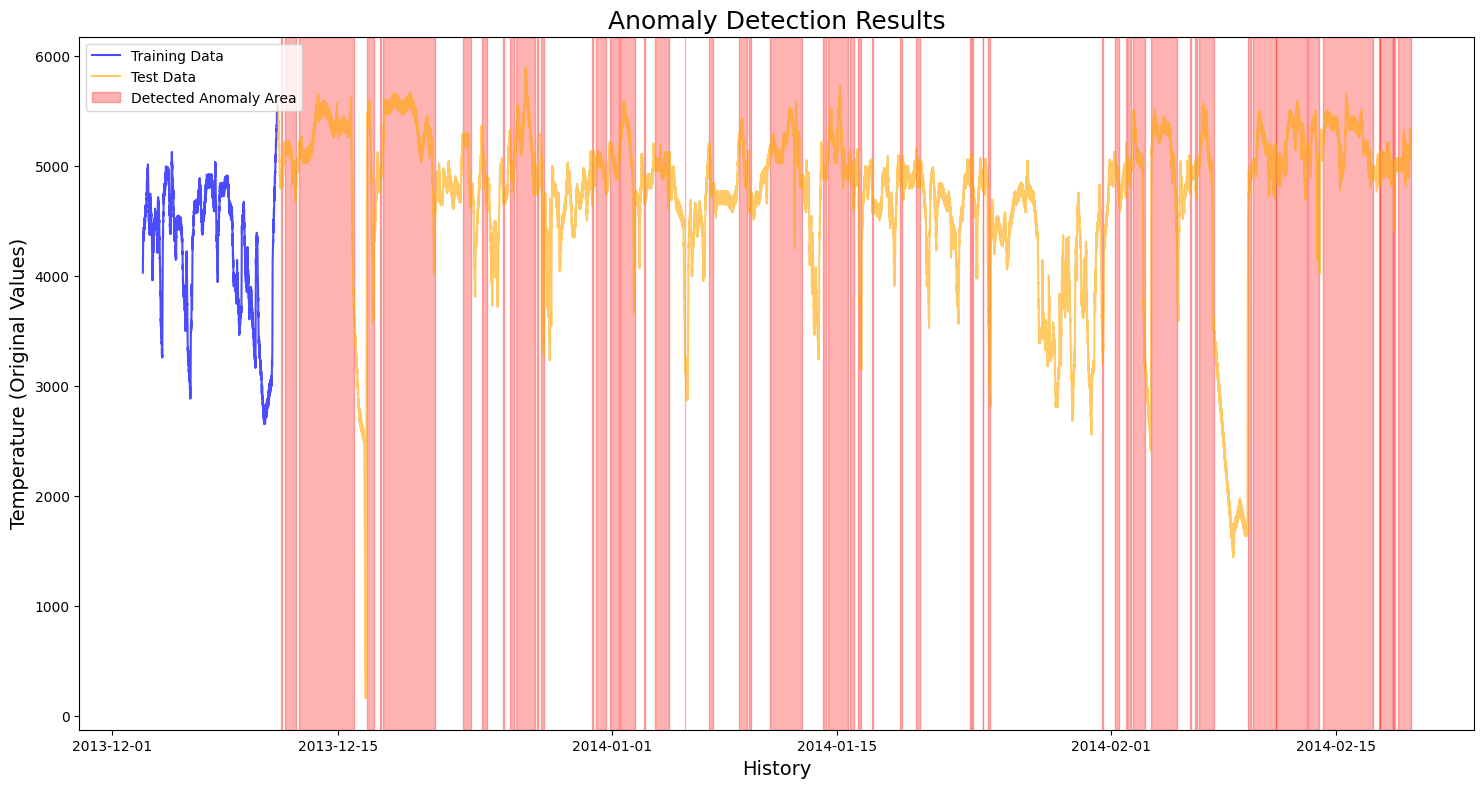

In [29]:
plt.figure(figsize=(18, 9))

plt.plot(
    train_df.index, 
    scaler.inverse_transform(train_df[['value']]), 
    label='Training Data', 
    color='blue',
    alpha=0.7
)
plt.plot(
    test_df.index, 
    scaler.inverse_transform(test_df[['value']]), 
    label='Test Data',
    color='orange',
    alpha=0.6
)

is_anomaly_region = False
anomaly_start = None
label_added = False

for index, row in anomaly_df.iterrows():
    
    if row['anomaly'] and not is_anomaly_region:
        is_anomaly_region = True
        anomaly_start = index
    
    elif not row['anomaly'] and is_anomaly_region:
        is_anomaly_region = False
        anomaly_end = index
        
        plt.axvspan(
            anomaly_start, anomaly_end, 
            color='red', 
            alpha=0.3,
            label='Detected Anomaly Area' if not label_added else None
        )
        label_added = True

if is_anomaly_region:
    plt.axvspan(
        anomaly_start, anomaly_df.index[-1], 
        color='red', 
        alpha=0.3,
        label='Detected Anomaly Area' if not label_added else None
    )

plt.title('Anomaly Detection Results', fontsize=18)
plt.xlabel('History', fontsize=14)
plt.ylabel('Temperature (Original Values)', fontsize=14)
plt.legend(loc='upper left')
plt.show()